# Importing libraries

In [184]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf
from math import sqrt
from scipy import stats
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
import pandas_datareader
import math
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta
from prettytable import PrettyTable
import cvxpy as cvx
from sklearn.covariance import LedoitWolf
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import requests
import json
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses
from sklearn.svm import SVR
import statsmodels.api as sm
import scipy.optimize as opt
from scipy.cluster.hierarchy import linkage, cut_tree, dendrogram
from scipy.spatial.distance import squareform
from fredapi import Fred
import getFamaFrenchFactors as gff
import quantstats as qs
from sklearn.linear_model import LinearRegression
from tabulate import tabulate

# Describing initial values

In [185]:
#Total years of traing model
years_training=1
# Define the end date
fecha = "2021-01-01"
end=fecha
# Convert the end date string to a datetime object
end_date = datetime.strptime(end, "%Y-%m-%d")
# Calculate the start date as one year before the end date
start_date = end_date - timedelta(days=365*years_training)
# Convert the start date to a string in the same format as the end date
start = start_date.strftime("%Y-%m-%d")

print("Start Date:", start)
print("End Date:", end)

Start Date: 2020-01-02
End Date: 2021-01-01


In [186]:
# Calculate the number of year form the date to today
def years_difference_from_today(date):
    # Convert the input date string to a datetime object
    date_object = datetime.strptime(date, '%Y-%m-%d')

    # Get today's date
    today = datetime.now()

    # Calculate the difference in years
    years_difference = today.year - date_object.year

    # Calculate the fraction of the current year
    fraction_of_year = (today - datetime(today.year, date_object.month, date_object.day)).days / 365

    # Check if the current month and day are before the input date's month and day
    if (today.month, today.day) < (date_object.month, date_object.day):
        years_difference -= 1

    # Add the fraction of the current year
    years_difference += fraction_of_year

    return years_difference

In [187]:
#Number of periods to change the portfolio allocation

years= years_difference_from_today(fecha)

# number of months
months = 2
periods = int(12* years / months)
leng_period= 30 * months

In [188]:
## define the stocks for our portfolio (via tickers) ###
assets = [ #Healthcare
          "JNJ", #(Johnson & Johnson)
          "PFE", #(Pfizer Inc.)
          "MRK", #(Merck & Co. Inc.)
          "LLY", #(Eli Lilly and company)
          "UNH", #(UnitedHealth Group Incorporated)
          "AMGN", #(Amgen Inc.)
          #Technology
          "MSFT", #(Microsoft Corporation)
          "GOOGL", #(Alphabet Inc. - Google)
          "META", #(Meta Platforms Inc. - Facebook)
          "NVDA", #(Nvidia)
          "AMD", #(Advanced micro devices)
          "TSLA", #(Tesla, Inc.)
          "CRM", #(Salesforce.com Inc.)
          # Finance
          "JPM", #(JPMorgan Chase & Co.)
          "MA", #(Mastercard)
          "BX", #(Blackstone)
          "AXP", #(American Express)
          "GS", #(The Goldman Sachs Group, Inc.)
          "BAC", #(Bank of America Corporation)
          "V", #(Visa Inc.)
          #Consumer goods
          "PG", #(Procter & Gamble Company)
          "KO", #(The Coca-Cola Company)
          "NKE", #(Nike, Inc.)
          "MCD", #(McDonald's Corporation)
          #Energy
          "XOM", #(Exxon Mobil Corporation)
          "CVX", #(Chevron Corporation)
          "SHEL", #(Royal Dutch Shell plc)
          "BP", #(BP p.l.c.)
          "COP", #(ConocoPhillips)
          #Retail
          "AMZN", #(Amazon.com, Inc.)
          "WMT", #(Walmart Inc.)
          "TGT", #(Target Corporation)
          "COST", #(Costco Wholesale Corporation)
          "HD", #(The Home Depot, Inc.)
          #Telecommunications
          "T", #(AT&T Inc.)
          "VZ", #(Verizon Communications Inc.)
          "TMUS", #(T-Mobile US, Inc.)
          #Utilities
          "NEE", #(NextEra Energy, Inc.)
          "DUK", #(Duke Energy Corporation)
          "SO", #(The Southern Company)
          "NRG", #(NRG Energy)
          "EXC", #(Exelon Corporation)
          "AEP", #(American Electric Power Company, Inc.)
          #Real Estate
          "SPG", #(Simon Property Group, Inc.)
          "AMT", #(American Tower Corporation)
          "EQIX", #(Equinix, Inc.)
          "PSA", #(Public Storage)
          "WELL", #(Welltower Inc.)
          #Transportation
          "UPS", #(United Parcel Service, Inc.)
          "FDX", #(FedEx Corporation)
          "DAL", #(Delta Air Lines, Inc.)
          "AAL", #(American Airlines Group Inc.)
          "BLDR", #(Builders first source)
          #"UBER", #(Uber Technologies, Inc.)                  No data before may 2018
          #"ROAD", #(Construction Partners, Inc)               No data before may 2018
          #cripto
          "BTC-USD", #Bitcoin
          "ETH-USD" #Ethereum
          ]

assets =sorted(assets)

## Micro and macroeconomic factors

### FRED

In [189]:
# Initialize Fred with your API key
api_key = '95c774645924b13f93458e248a922d67'
fred = Fred(api_key=api_key)
# Fetch GDP data (quarterly)
gdp = fred.get_series('GDP')

# Fetch Inflation (Consumer Price Index for All Urban Consumers)
inflation = fred.get_series('CPIAUCSL')

# Fetch Unemployment rate (monthly)
unemployment = fred.get_series('UNRATE')

# Fetch Federal Funds Rate (interest rate, monthly)
interest_rates = fred.get_series('FEDFUNDS')

# Combine the data into a DataFrame
macroeconomic_data = pd.concat([gdp, inflation, unemployment, interest_rates], axis=1)
macroeconomic_data.columns = ['GDP', 'Inflation', 'Unemployment', 'Interest Rates']

# Industrial Production Index (a proxy for industry-specific data)
industrial_production = fred.get_series('INDPRO')

# Average Hourly Earnings of All Employees, Total Private
hourly_earnings = fred.get_series('CES0500000003')

# Housing starts (a measure of consumer sentiment in the housing market)
housing_starts = fred.get_series('HOUST')

# Combine with other microeconomic data
microeconomic_data = pd.concat([industrial_production, hourly_earnings, housing_starts], axis=1)
microeconomic_data.columns = ['Industrial Production','Average Hourly Earnings',  'Housing Starts']

In [190]:
# Combine macro and microeconomic data
combined_data = pd.concat([macroeconomic_data, microeconomic_data], axis=1)

# Align the data to a common frequency (e.g., monthly)
combined_data = combined_data.resample('M').ffill()  # Forward-fill to avoid NaN gaps

#Get data only from the start date
combined_data= combined_data[combined_data.index > start]


In [191]:
# Resample to daily frequency
macro_daily = combined_data.resample('D').asfreq()

# Forward-fill NaN values for daily frequency
macro_daily.fillna(method='ffill', inplace=True)

#### Daily data

In [192]:
# U.S. Dollars to Euro Spot Exchange Rate daily
dollar_euro = fred.get_series('DEXUSEU')

# Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis
ten_Y = fred.get_series('DEXUSEU')

# Dow Jones Industrial Average
Dow = fred.get_series('DJIA')

# S&P 500
sp500 = fred.get_series('SP500')

# NASDAQ Composite Index
nasdaq = fred.get_series('NASDAQCOM')

# CBOE Gold ETF Volatility Index
gold = fred.get_series('GVZCLS')

# CBOE Crude Oil ETF Volatility Index
oil = fred.get_series('OVXCLS')

# CBOE Russell 2000 Volatility Index
russell = fred.get_series('RVXCLS')

# Combine daily data
daily_data = pd.concat([dollar_euro, ten_Y, Dow,  sp500, nasdaq, gold, oil, russell], axis=1)
daily_data.columns = ['U.S. Dollars to Euro', 'Treasury Securities at 10-Year', 'Dow Jones','S&P 500', 'NASDAQ', 'Gold', 'Crude oil', 'Russell 2000']
#Get data only from the start date
daily_data= daily_data[daily_data.index > start]

In [193]:
# Combine macro and daily data
macro= pd.concat([macro_daily, daily_data], axis=1).dropna()
macro

,GDP,Inflation,Unemployment,Interest Rates,Industrial Production,Average Hourly Earnings,Housing Starts,U.S. Dollars to Euro,Treasury Securities at 10-Year,Dow Jones,S&P 500,NASDAQ,Gold,Crude oil,Russell 2000
2020-01-31,21706.513,258.906,3.6,1.55,101.3768,28.44,1572.0,1.1082,1.1082,28256.03,3225.52,9150.94,13.50,40.35,20.33
2020-02-03,21706.513,258.906,3.6,1.55,101.3768,28.44,1572.0,1.1062,1.1062,28399.81,3248.92,9273.40,12.48,41.81,19.78
2020-02-04,21706.513,258.906,3.6,1.55,101.3768,28.44,1572.0,1.1043,1.1043,28807.63,3297.59,9467.97,12.01,39.44,17.54
2020-02-05,21706.513,258.906,3.6,1.55,101.3768,28.44,1572.0,1.1006,1.1006,29290.85,3334.69,9508.68,11.32,37.88,16.41
2020-02-06,21706.513,258.906,3.6,1.55,101.3768,28.44,1572.0,1.0979,1.0979,29379.77,3345.78,9572.15,11.45,36.44,16.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-24,28284.498,312.230,3.8,5.33,102.6577,34.68,1321.0,1.0687,1.0687,38460.92,5071.63,15712.75,17.45,29.04,22.34
2024-04-25,28284.498,312.230,3.8,5.33,102.6577,34.68,1321.0,1.0721,1.0721,38085.80,5048.42,15611.76,17.32,28.34,22.16
2024-04-26,28284.498,312.230,3.8,5.33,102.6577,34.68,1321.0,1.0686,1.0686,38239.66,5099.96,15927.90,16.92,27.81,21.04
2024-04-29,28284.498,312.230,3.8,5.33,102.6577,34.68,1321.0,1.0717,1.0717,38386.09,5116.17,15983.08,16.92,27.84,20.63


### EIA api

In [194]:
api_url = 'https://api.eia.gov/v2/steo/data'

params = {"api_key": "whsAp9dwvJg3dXf6Dx1y4BlbFji8hzZExBuZaL4g"}

header = {
    "frequency": "monthly",
    "data": [
        "value"
    ],
    "facets": {
        "seriesId": [
            "COPR_OPEC", #Global crude oil production
            "PAPR_WORLD",
            'BREPUSS',
            'COPR_OPEC',
            'D2TCPUS',
            'PASXPUS',
            'RAIMUUS',
            'T3_STCHANGE_US'
        ]
    },
    "start": start,
    "end": "2024-04",
    "sort": [
        {
            "column": "period",
            "direction": "desc"
        }
    ],
    "offset": 0,
    "length": 5000
}

r = requests.get(api_url, params=params, headers={"X-Params": json.dumps(header)})

In [195]:
# Transform data to a dataframe
file = r.json()
eia=pd.DataFrame(file['response']['data'])
# Set the date as a index
eia['period']=pd.to_datetime(eia['period'])
eia.set_index('period', inplace=True)
# Transform the data to have all the macroeconomic data in columns
eai_macro = eia.pivot_table(index='period', columns='seriesId', values='value', aggfunc='first')

In [196]:
# Resample to daily frequency
eai_daily = eai_macro.resample('D').asfreq()

# Forward-fill NaN values for daily frequency
eai_daily.fillna(method='ffill', inplace=True)
eai_daily

seriesId,COPR_OPEC,PAPR_WORLD,PASXPUS,RAIMUUS,T3_STCHANGE_US
period,,,,,
2020-01-01,27.32,101.00411098,1299.893185,53.87,-.58108270968
2020-01-02,27.32,101.00411098,1299.893185,53.87,-.58108270968
2020-01-03,27.32,101.00411098,1299.893185,53.87,-.58108270968
2020-01-04,27.32,101.00411098,1299.893185,53.87,-.58108270968
2020-01-05,27.32,101.00411098,1299.893185,53.87,-.58108270968
...,...,...,...,...,...
2024-03-28,26.895,102.53086846,1212.4401753,78.53,.20367834654
2024-03-29,26.895,102.53086846,1212.4401753,78.53,.20367834654
2024-03-30,26.895,102.53086846,1212.4401753,78.53,.20367834654


# Machine Learning expected returns

## Random Forest

In [197]:
#In this fuction the df_prices will have the
def RF(df):
  #Choose only the assets as output
  returns= df[assets]
  returns = returns.pct_change(periods=leng_period).shift(-leng_period)
  # Split into training and test sets (without using `train_test_split`)
  # For training and testing we are using the data leng_periods before because the target will be the mean return of the leng_periods later
  train_size = int(0.9 * (len(df)-leng_period))  # Example 80% train, 20% test
  #Using all the micro macro and asset as input
  X_train = df.iloc[:train_size]
  X_test = df.iloc[train_size:(len(df)-leng_period)]
  #using only assets return as output
  y_train = returns[:train_size]
  y_test = returns[train_size:(len(df)-leng_period)]
  # Standardize features for training and test
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  X_scaled = scaler.transform(df)
  best_params= {'bootstrap': False, 'max_depth': 26, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 910}
  # Train a Random Forest model
  model = RandomForestRegressor(**best_params, random_state=42)
  model.fit(X_train_scaled, y_train)

  # Predict on the test set
  y_pred = model.predict(X_test_scaled)

  # Evaluate with Mean Squared Error
  mse = mean_squared_error(y_test, y_pred)

  print("Mean Squared Error:", mse)
  prediction = model.predict(X_scaled)
  prediction = prediction[-leng_period:].mean(axis=0)
  return prediction, mse

## XGBoost

In [198]:
#In this fuction the df_prices will have the
def XG(df):
  #Choose only the assets as output
  returns= df[assets]
  returns = returns.pct_change(periods=leng_period).shift(-leng_period)
  # Split into training and test sets (without using `train_test_split`)
  # For training and testing we are using the data leng_periods before because the target will be the mean return of the leng_periods later
  train_size = int(0.8 * (len(df)-leng_period))  # Example 80% train, 20% test
  #Using all the micro macro and asset as input
  X_train = df.iloc[:train_size]
  X_test = df.iloc[train_size:(len(df)-leng_period)]
  #using only assets return as output
  y_train = returns[:train_size]
  y_test = returns[train_size:(len(df)-leng_period)]
  # Standardize features for training and test
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  X_scaled = scaler.transform(df)
  best_params = {'colsample_bytree': 0.8659851446851979, 
                 'gamma': 0.013808385936852352, 
                 'learning_rate': 0.06788648955075587, 
                 'max_depth': 6, 
                 'min_child_weight': 3, 
                 'n_estimators': 441, 
                 'reg_alpha': 0.32815266747473193, 
                 'reg_lambda': 0.1550416167277442, 
                 'subsample': 0.8945522664931593}
  # Train a XGBoost using squarederror as objetive function
  model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, **best_params )
  model.fit(X_train_scaled, y_train)

  # Predict on the test set
  y_pred = model.predict(X_test_scaled)

  # Evaluate with Mean Squared Error
  mse = mean_squared_error(y_test, y_pred)

  print("Mean Squared Error:", mse)
  prediction = model.predict(X_scaled)
  prediction = prediction[-leng_period:].mean(axis=0)
  return prediction, mse

## Neural Networks

In [199]:
def NN(df):
  #Choose only the assets as output
  returns= df[assets]
  returns = returns.pct_change(periods=leng_period).shift(-leng_period)
  # Split into training and test sets (without using `train_test_split`)
  # For training and testing we are using the data leng_periods before because the target will be the mean return of the leng_periods later
  train_size = int(0.8 * (len(df)-leng_period))  # Example 80% train, 20% test
  #Using all the micro macro and asset as input
  X_train = df.iloc[:train_size]
  X_test = df.iloc[train_size:(len(df)-leng_period)]
  #using only assets return as output
  y_train = returns[:train_size]
  y_test = returns[train_size:(len(df)-leng_period)]
  # Standardize features for training and test
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  X_scaled = scaler.transform(df)

  # Train a neural network
  model = keras.Sequential([
      layers.InputLayer(input_shape=(df.shape[1],)),  # Input layer
      layers.Dense(64, activation='relu'),  # First hidden layer with 64 neurons
      layers.Dropout(0.2),  # Dropout with rate of 0.2
      layers.Dense(64, activation='relu'),  # Second hidden layer with 64 neurons
      layers.Dropout(0.2),  # Dropout with rate of 0.2
      layers.Dense(len(assets))  # Output layer for predicting return prices
  ])

  # Compile the model with a low learning rate
  model.compile(
      optimizer=optimizers.Adam(learning_rate=1e-05),  # Learning rate of 1e-05
      loss=losses.MeanSquaredError(),  # Mean Squared Error for loss function
      metrics=['mae']  # Mean Absolute Error as a metric
  )
  # Train the model (using some validation data for evaluation)
  model.fit(X_train_scaled, y_train, epochs=100, validation_split=0.2)  # 20% data for validation


  # Predict on the test set
  y_pred = model.predict(X_test_scaled)

  # Evaluate with Mean Squared Error
  mse = mean_squared_error(y_test, y_pred)

  print("Mean Squared Error:", mse)
  prediction = model.predict(X_scaled)
  prediction = prediction[-leng_period:].mean(axis=0)
  return prediction ,mse

## Support Vector Machines (SVM)

In [200]:
#In this fuction the df_prices will have the
def SV(df):
  #Choose only the assets as output
  returns= df[assets]
  returns = returns.pct_change(periods=leng_period).shift(-leng_period)
  # Split into training and test sets (without using `train_test_split`)
  # For training and testing we are using the data leng_periods before because the target will be the mean return of the leng_periods later
  train_size = int(0.8 * (len(df)-leng_period))  # Example 80% train, 20% test
  #Using all the micro macro and asset as input
  X_train = df.iloc[:train_size]
  X_test = df.iloc[train_size:(len(df)-leng_period)]
  #using only assets return as output
  y_train = returns[:train_size]
  y_test = returns[train_size:(len(df)-leng_period)]
  # Standardize features for training and test
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  X_scaled = scaler.transform(df)

  # Dictionary to store the results of multiple SVR models
  predictions = {}
  mse =  {}
  # Train an SVR model for each asset column
  for asset in assets:
      y_train = returns[asset][:train_size]
      y_test = returns[asset][train_size:(len(df) - leng_period)]

      model = SVR(kernel='rbf', C=100, epsilon=0.1)  # SVR with RBF kernel, regularization C, and epsilon

      model.fit(X_train_scaled, y_train)  # Fit the model

      # Predict on the test set
      y_pred = model.predict(X_test_scaled)

      # Evaluate with Mean Squared Error for each model
      mse[asset] = mean_squared_error(y_test, y_pred)


      # Prediction on full data
      asset_prediction = model.predict(X_scaled)
      predictions[asset] = asset_prediction[-leng_period:].mean(axis=0)

  #print(f"Mean Squared Error ", mse)
  predictions = pd.Series(predictions)
  mse = sum(mse.values()) / len(mse)
  return predictions, mse

# Calculation weights portfolio

## Markowitz using CVXPY

In [201]:
# Initial weight calculation using markowitz algorithm
def initial_weight(df_prices):
    # We transform the data to its logarithmic returns
    df = np.log(df_prices).diff()
    # Drop the first row because we loose information for the logarithmic return.
    df = df.dropna()  # this is a dataframe

    # Compute the Expected Returns, we multiply daily return by 252
    #because there are 252 business days in the US.
    exp_returns = df.mean()*252
    # compute the covariance matrix
    cova = df.cov()*252
    #number of assets
    m=exp_returns.shape[0]
    # WANT: optimal portfolio with the following constraints
    # 1. no short sales are allowed  that is the weights for all stocks are >=0
    # 2. Maximum value of 15%
    # 3. Minimum value of 5%
    # 4. The asset could take the minimun value or Zero

    #def optimize_portfolio(exp_returns, index_weights, scale=.0000):
    cov_real = np.array(cova)   # variance-covariance matrix of assets
    X = np.random.multivariate_normal(mean=np.zeros(len(assets)),  #get multivariable normal distribution using mean zero
                                      cov=cov_real,
                                      size=len(assets))
    cov = LedoitWolf().fit(X) # calculation covariance using shrinkage method of ledoit
    Q=cov.covariance_
    q = np.array(exp_returns) # q is the exptected returns of assets

    #  Constraints

    h =np.ones(m)*0.02  # Minimum value
    k=np.zeros(m)       # For values zero
    j =np.ones(m)*0.15   # Maximum value

    # Define and solve the quadratic problem using CVXPY:
    # ===================================================
    x = cvx.Variable(m)
    turnover=0.20
    k=0.01 # % fixed cost

    objective=cvx.Maximize((-1/2)*cvx.quad_form(x, Q) + q.T @ x)


    constraints=[x >= cvx.multiply(k, h), # Give a minimum value and also posivility of choose 0
                  x <= j, # Maximum value
                  x >= 0,
                  cvx.sum(x) == 1] # Constrain sum 1

    prob = cvx.Problem(objective,constraints)

    prob.solve()
    #retrieve the weights of the optimized portfolio
    x_values = x.value

    # Eliminate the small numbers
    threshold = 1e-10
    weights=np.where(np.abs(x_values) < threshold, 0, x_values)

    return weights

In [202]:
#Markowitz algorithm using the initial weight to calculate the cost contraint due to the change in the asset
def markowitz(df_prices, initial_weight, expected_returns):
    # We transform the data to its logarithmic returns
    df = np.log(df_prices).diff()
    # Drop the first row because we loose information for the logarithmic return.
    df = df.dropna()  # this is a dataframe

    # Compute the Expected Returns, we multiply daily return by 252
    #because there are 252 business days in the US.
    #exp_returns = df.mean()*252

    #Calculate expected returns using the input
    exp_returns = expected_returns*252
    # compute the covariance matrix
    cova = df.cov()*252
    #number of assets
    m=exp_returns.shape[0]
    # WANT: optimal portfolio with the following constraints
    # 1. no short sales are allowed  that is the weights for all stocks are >=0
    # 2. Maximum value of 15%
    # 3. Minimum value of 5%
    # 4. The asset could take the minimun value or Zero

    #def optimize_portfolio(exp_returns, index_weights, scale=.0000):
    cov_real = np.array(cova)   # variance-covariance matrix of assets
    X = np.random.multivariate_normal(mean=np.zeros(len(assets)),  #get multivariable normal distribution using mean zero
                                      cov=cov_real,
                                      size=len(assets))
    cov = LedoitWolf().fit(X) # calculation covariance using shrinkage method of ledoit
    Q=cov.covariance_
    q = np.array(exp_returns) # q is the exptected returns of assets

    #  Constraints

    h =np.ones(m)*0.02  # Minimum value
    k=np.zeros(m)       # For values zero
    j =np.ones(m)*0.15   # Maximum value

    # Define and solve the quadratic problem using CVXPY:
    # ===================================================
    x = cvx.Variable(m)

    turnover=0.20
    k=0.01 # % fixed cost

    cost = k * cvx.norm(x-initial_weight, 1) # transaction cost

    objective=cvx.Maximize((-1/2)*cvx.quad_form(x, Q) + q.T @ x - cost)


    constraints=[#x >= cvx.multiply(k, h), # Give a minimum value and also posivility of choose 0
                  x <= j, # Maximum value
                  #cvx.abs(x-initial_weight) <= turnover, #turnover constraint
                  x >= 0,
                  cvx.sum(x) == 1]

    prob = cvx.Problem(objective,constraints)

    prob.solve()
    #retrieve the weights of the optimized portfolio
    x_values = x.value

    # Eliminate the small numbers
    threshold = 1e-10
    weights=np.where(np.abs(x_values) < threshold, 0, x_values)

    return weights


## Markowitz using Scipy as optimizer

In [203]:
# Portfolio optimization function
def initial_weight_scipy(df_prices, min_assets=7, penalty_factor=10):
    df = np.log(df_prices).diff().dropna()
    # Calculation of exp returns using random forest
    exp_returns, mse = RF(df_prices)
    exp_returns= exp_returns * 252
    cov_matrix = df.cov() * 252

    m = len(exp_returns)

    # Objective function with a penalty if fewer than 20 assets are selected
    def objective(x):
        risk = 0.5 * (x @ cov_matrix @ x)
        expected_return = exp_returns @ x
        # Count how many assets are greater than a small threshold (e.g., 0.01)
        non_zero_count = np.sum(x > 0.005)
        # Penalty for fewer than the minimum required assets
        penalty = penalty_factor * max(0, min_assets - non_zero_count)
        return risk - expected_return + penalty  # Minimize risk, maximize return, with penalty

    # Constraints
    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Portfolio must sum to 100%
    ]

    # Bounds for asset weights (0.01 is the lower bound to consider an asset non-zero)
    bounds = [(0.0, 0.15) for _ in range(m)]  # Weight bounds (1% to 15%)

    # Initial guess (equal distribution)
    initial_guess = np.full(m, 1/m)

    # Solver options
    options = {
        'ftol': 1e-6,  # Convergence tolerance
        'maxiter': 1000,  # Maximum iterations
    }

    # Optimization using SLSQP
    result = opt.minimize(objective, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints, options=options)

    if not result.success:
        raise Exception("Optimization failed:", result.message)

    # Eliminate the small numbers
    threshold = 1e-10
    weights=np.where(np.abs(result.x) < threshold, 0, result.x)

    return weights  # Optimized weights



In [204]:
# Portfolio optimization function
def weight_scipy(df_prices, initial_weight, expected_returns, min_assets=7, penalty_factor=10, transaction_cost=0.01, turnover_limit=0.20):
    df = np.log(df_prices).diff().dropna()
    # Calculation of exp returns using random forest
    exp_returns = expected_returns * 252
    cov_matrix = df.cov() * 252

    m = len(exp_returns)

    # Objective function with a penalty if fewer than 20 assets are selected
    def objective(x):
        risk = 0.5 * (x @ cov_matrix @ x)
        expected_return = exp_returns @ x
        # Count how many assets are greater than a small threshold (e.g., 0.01)
        non_zero_count = np.sum(x > 0.005)
        # Penalty for fewer than the minimum required assets
        penalty = penalty_factor * max(0, min_assets - non_zero_count)
        # Transaction cost based on absolute weight changes from initial weights
        cost = transaction_cost * np.sum(np.abs(x - initial_weight))
        return risk - expected_return + penalty + cost  # Minimize risk, maximize return, with penalty

    # Constraints
    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Portfolio must sum to 100%
        #{'type': 'ineq', 'fun': lambda x: turnover_limit - np.sum(np.abs(x - initial_weight))},  # Turnover limit
    ]

    # Bounds for asset weights (0.01 is the lower bound to consider an asset non-zero)
    bounds = [(0.0, 0.15) for _ in range(m)]  # Weight bounds (1% to 15%)

    # Initial guess (equal distribution)
    initial_guess = initial_weight

    # Solver options
    options = {
        'ftol': 1e-6,  # Convergence tolerance
        'maxiter': 5000,  # Maximum iterations
    }

    # Optimization using SLSQP
    result = opt.minimize(objective, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints, options=options)

    if not result.success:
        raise Exception("Optimization failed:", result.message)

    # Eliminate the small numbers
    threshold = 1e-10
    weights=np.where(np.abs(result.x) < threshold, 0, result.x)

    return weights  # Optimized weights


## HRP algorithm

In [205]:
#Using code of Marcos lopex del pradro <lopezdeprado@lbl.gov>
# Hierarchical Risk Parity
# Allocate portfolio weights using Hierarchical Risk Parity
def preprocess_data(df_prices):
    df = np.log(df_prices).diff().dropna()  # Log returns
    #exp_returns = RF(df_prices) * 252  # Expected returns on annual basis using random forest
    exp_returns = df.mean()*252
    cov_matrix = df.cov() * 252  # Covariance matrix
    return exp_returns, cov_matrix

def hierarchical_clustering(cov_matrix):
    # Create a distance matrix from the correlation matrix
    corr_matrix = cov_matrix / (np.sqrt(np.diag(cov_matrix))[:, None] * np.sqrt(np.diag(cov_matrix))[None, :])
    distance_matrix = np.sqrt(0.5 * (1 - corr_matrix))

    # Convert to symmetric and set diagonal to zero
    distance_matrix_clean = distance_matrix.to_numpy()
    np.fill_diagonal(distance_matrix_clean, 0)

    # Hierarchical clustering using Ward's method
    linkage_matrix = linkage(squareform(distance_matrix_clean), method='ward')
    return linkage_matrix

def get_quasi_diag(linkage_matrix):
    # Sort clustered items by distance
    sort_ix = pd.Series([linkage_matrix[-1, 0], linkage_matrix[-1, 1]], dtype=int)
    num_items = linkage_matrix[-1, 3]  # Number of original items

    while sort_ix.max() >= num_items:
        # Adjust indices to make space
        sort_ix.index = range(0, len(sort_ix) * 2, 2)
        # Get the clusters greater than the number of items
        df0 = sort_ix[sort_ix >= num_items]
        # Integer conversion for indexing
        i = df0.index
        j = (df0.values.astype(int) - num_items).astype(int)
        # Re-assign values in sort_ix
        sort_ix[i] = linkage_matrix[j, 0].astype(int)
        # Create a new Series with new indices and sort
        df0 = pd.Series(linkage_matrix[j, 1].astype(int), index=i + 1)
        sort_ix = pd.concat([sort_ix, df0]).sort_index()
        sort_ix.index = range(len(sort_ix))  # Re-index
    return sort_ix.tolist()

def getIVP(cov,**kargs):
    # Compute the inverse-variance portfolio
    ivp=1./np.diag(cov)
    ivp/=ivp.sum()
    return ivp

def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

def get_rec_bipart(cov_matrix, sorted_ix):
    # Compute HRP allocations recursively
    w = pd.Series(1, index=sorted_ix)  # Initialize all items with equal weights
    c_items = [sorted_ix]  # Initialize all items in one cluster
    # convert the index names as numbers
    custom_indices = list(range(len(cov_matrix)))
    cov_matrix.index = custom_indices
    cov_matrix.columns = custom_indices
    while len(c_items) > 0:
        c_items=[i[j:k] for i in c_items for j,k in ((0,len(i)//2), (len(i)//2,len(i))) if len(i)>1] # bi-section
        for i in range(0, len(c_items), 2):  # Parse in pairs
            c_items0 = c_items[i]  # Cluster 1
            c_items1 = c_items[i + 1]  # Cluster 2

            # Calculate the variance for each cluster
            c_var0=getClusterVar(cov_matrix,c_items0)
            c_var1=getClusterVar(cov_matrix,c_items1)
            # Allocate weights based on variance
            alpha = 1 - c_var0 / (c_var0 + c_var1)
            w[c_items0] *= alpha        # weight 1
            w[c_items1] *= (1 - alpha)  # weight 2
    return w

def weights_hrp(df_prices):
    exp_returns, cov_matrix = preprocess_data(df_prices)

    # Perform hierarchical clustering
    linkage_matrix = hierarchical_clustering(cov_matrix)

    # Get the quasi-diagonalized order
    sorted_ix = get_quasi_diag(linkage_matrix)
    # Perform recursive bisection to get weights
    hrp_weights = get_rec_bipart(cov_matrix, sorted_ix)
    sort_weights = hrp_weights.sort_index()
    sort_weights = sort_weights.tolist()
    return sort_weights

In [206]:
assets =sorted(assets)
# Acquire data
end_period = (datetime.strptime(end, "%Y-%m-%d") + timedelta(days=(periods+1)*leng_period)).strftime("%Y-%m-%d")
print(end_period)
df_prices = yf.download(assets,start=start,end=end_period)['Adj Close']
df_prices_all = df_prices.dropna()
market_prices_all = yf.download("^GSPC",start=start,end=end_period)['Adj Close']
print(start, end)
#Initial weight using CVXPY
#initial_weight = initial_weight(df_prices_all[start:end])
#Initial weight using spicy
initial_weight = initial_weight_scipy(df_prices_all[start:end])
ini_weight = initial_weight
print(initial_weight)

2024-06-14


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed


2020-01-02 2021-01-01
Mean Squared Error: 0.020795845214532673
[7.74051680e-10 1.41810515e-10 0.00000000e+00 6.16484617e-10
 6.21685693e-10 2.21414824e-10 0.00000000e+00 2.16946312e-10
 9.99999995e-02 9.80712390e-10 1.49999998e-01 0.00000000e+00
 3.02353611e-10 0.00000000e+00 0.00000000e+00 2.99618018e-10
 0.00000000e+00 0.00000000e+00 4.92786166e-10 1.49999999e-01
 0.00000000e+00 1.49999999e-01 0.00000000e+00 0.00000000e+00
 3.37376318e-10 4.37704931e-10 0.00000000e+00 2.07762613e-10
 3.98284000e-10 4.76237653e-10 2.88455395e-10 1.59353357e-10
 5.73404362e-10 2.68466936e-10 0.00000000e+00 1.49999999e-01
 5.87462461e-10 0.00000000e+00 0.00000000e+00 2.46074213e-10
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.27380706e-10 1.49999999e-01 0.00000000e+00 1.49999999e-01
 0.00000000e+00 0.00000000e+00 3.16726163e-10 2.48240498e-10
 2.70492028e-10 0.00000000e+00 7.14678039e-10]


If there is singularity problem like "LinAlgError: SVD did not converge" Check the values of the assets. Could have nan value because there not exist in yahoo

In [175]:
# Join the micro and macroeconomic with all the asset to use it as input in the machine learning
macro_prices = df_prices_all.join(macro, how='inner')  # Join the Fred economic variable with the assets value
macro_prices = macro_prices.join(eai_daily, how='inner') # Join the EAI economic variable with the preview table

# Table differents periods

## Calculate weights of all periods

In [75]:

total_weight=[]
min_assets= 7
for j in range(1,5):
    # number months J
    periods = int(12* years / j)
    #Number of days of the period
    leng_period=j*30
    end1=end
    weights=[]
    table = PrettyTable()
    table.field_names = ["Start Date", "End Date"]
    for i in range(periods):
      # Convert the end date string to a datetime object
      end_date = datetime.strptime(end1, "%Y-%m-%d")
      # Calculate the start date as one year before the end date
      start_date = end_date - timedelta(days=365*years_training)
      # Convert the start date to a string in the same format as the end date
      start = start_date.strftime("%Y-%m-%d")
      end1 = end_date.strftime("%Y-%m-%d")
      print(start, end1)
      #Call the prices from prices of all the asssets
      df_prices=df_prices_all[start:end1]
      #Machine learning algorithm to calculate the expected returns
      ml_data=macro_prices[start:end1]
      expected_returns, mse = SV(ml_data)
      table.add_row([start, end1])
      #weigt using CVXPY
      #weight=markowitz(df_prices, initial_weight, expected_returns)
      #weigt using spicy optimizer
      weight=weight_scipy(df_prices, initial_weight, expected_returns, min_assets=min_assets)
      #weight using HRP
      #weight = weights_hrp(df_prices)
      # Append the weights for this period to the matrix
      weights.append(weight)
      end_date += timedelta(days=leng_period)
      end1 = end_date.strftime("%Y-%m-%d")
      initial_weight = weight
    total_weight.append(weights)
    print(table)

2020-01-02 2021-01-01
2020-02-01 2021-01-31
2020-03-02 2021-03-02
2020-04-01 2021-04-01
2020-05-01 2021-05-01
2020-05-31 2021-05-31
2020-06-30 2021-06-30
2020-07-30 2021-07-30
2020-08-29 2021-08-29
2020-09-28 2021-09-28
2020-10-28 2021-10-28
2020-11-27 2021-11-27
2020-12-27 2021-12-27
2021-01-26 2022-01-26
2021-02-25 2022-02-25
2021-03-27 2022-03-27
2021-04-26 2022-04-26
2021-05-26 2022-05-26
2021-06-25 2022-06-25
2021-07-25 2022-07-25
2021-08-24 2022-08-24
2021-09-23 2022-09-23
2021-10-23 2022-10-23
2021-11-22 2022-11-22
2021-12-22 2022-12-22
2022-01-21 2023-01-21
2022-02-20 2023-02-20
2022-03-22 2023-03-22
2022-04-21 2023-04-21
2022-05-21 2023-05-21
2022-06-20 2023-06-20
2022-07-20 2023-07-20
2022-08-19 2023-08-19
2022-09-18 2023-09-18
2022-10-18 2023-10-18
2022-11-17 2023-11-17
2022-12-17 2023-12-17
2023-01-16 2024-01-16
2023-02-15 2024-02-15
2023-03-17 2024-03-16
+------------+------------+
| Start Date |  End Date  |
+------------+------------+
| 2020-01-02 | 2021-01-01 |
| 2020-0

## Evaluation of portfolio

In [76]:
start= fecha
start_date = datetime.strptime(start, "%Y-%m-%d")
end_date = start_date + timedelta(days=leng_period*periods)
end = end_date.strftime("%Y-%m-%d")

print("Start Date:", start)
print("End Date:", end)

initial_market_prices = yf.download("^GSPC",start=start,end=end)['Adj Close']
initial_df_prices = yf.download(assets,start=start,end=end)['Adj Close']
initial_df_prices = initial_df_prices.dropna()

Start Date: 2021-01-01
End Date: 2024-04-15


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  55 of 55 completed


In [77]:
def count_differing_values(array1, array2, threshold):
    # Convert lists to numpy arrays
    array1 = np.array(array1)
    array2 = np.array(array2)

    # Calculate absolute difference between arrays
    diff = np.abs(array1 - array2)
    # Count differing values based on threshold
    differing_count = np.sum(diff > threshold)
    return differing_count

In [78]:
portfolio_full=[]
for j in range(1,5):
    start1=start
    Total_invest=1_000
    bl_portfolio = []
    market=[]
    portfolio=[]
    table = PrettyTable()
    table.field_names = ["Start Date", "End Date"]
    weights = total_weight [j-1]
    for x in range(periods):
        # Convert the start date string to a datetime object
        start_date = datetime.strptime(start1, "%Y-%m-%d")+ timedelta(days=1)
        #sum leng period to the end date
        end_date = start_date + timedelta(days=leng_period)
        # Convert the end date to a string in the same format as the end date
        end = end_date.strftime("%Y-%m-%d")
        start1= start_date.strftime("%Y-%m-%d")
        print(start1, end)
        table.add_row([start1, end])
        #Call the prices from market
        market_prices=market_prices_all[start1:end]
        #Call the prices from prices of all the asssets
        df_prices = df_prices_all[start1:end]
        portfolio= np.zeros(len(df_prices))
        # Loop through each asset and its weight, and calculate the contribution to the portfolio
        for i in range(len(assets)):
            asset_name = assets[i]
            #print(asset_name,df_prices[asset_name][0])
            asset_price = df_prices[asset_name]/df_prices[asset_name][0]
            asset_weight = weights[x][i]
            portfolio += asset_price * asset_weight
        portf = portfolio*Total_invest

        # Recalculation of the new total invest by the end of the period
        cost = 0.15 # price for buying or sell a faction of a share (hapi)
        if x==0:
            transactions=count_differing_values(weights[x], initial_weight, 1e-3)
        else:
            transactions = count_differing_values(weights[x], weights[x-1], 1e-3)
        total_cost = transactions*cost
        Total_invest=portfolio[-1]*Total_invest-total_cost
        bl_portfolio.append(portf)
        start_date += timedelta(days=leng_period)
        start1= start_date.strftime("%Y-%m-%d")
        #convert to a dataframe
        df_portfolio=pd.DataFrame(bl_portfolio)
        # Replace all the nan to value 0. When you do a dataframe it will create several row per each run and the columns are the dates
        df_portfolio.fillna(0, inplace=True)

        #transpose to have the date as row and all the run as columns
        df_portfolio = df_portfolio.transpose()
        #sum all the columns in the same row to have and unique value per row
        df_portfolio = df_portfolio.sum(axis=1)
    print(table)
    portfolio_full.append(df_portfolio)

2021-01-02 2021-05-02
2021-05-03 2021-08-31
2021-09-01 2021-12-30
2021-12-31 2022-04-30
2022-05-01 2022-08-29
2022-08-30 2022-12-28
2022-12-29 2023-04-28
2023-04-29 2023-08-27
2023-08-28 2023-12-26
2023-12-27 2024-04-25
+------------+------------+
| Start Date |  End Date  |
+------------+------------+
| 2021-01-02 | 2021-05-02 |
| 2021-05-03 | 2021-08-31 |
| 2021-09-01 | 2021-12-30 |
| 2021-12-31 | 2022-04-30 |
| 2022-05-01 | 2022-08-29 |
| 2022-08-30 | 2022-12-28 |
| 2022-12-29 | 2023-04-28 |
| 2023-04-29 | 2023-08-27 |
| 2023-08-28 | 2023-12-26 |
| 2023-12-27 | 2024-04-25 |
+------------+------------+
2021-01-02 2021-05-02
2021-05-03 2021-08-31
2021-09-01 2021-12-30
2021-12-31 2022-04-30
2022-05-01 2022-08-29
2022-08-30 2022-12-28
2022-12-29 2023-04-28
2023-04-29 2023-08-27
2023-08-28 2023-12-26
2023-12-27 2024-04-25
+------------+------------+
| Start Date |  End Date  |
+------------+------------+
| 2021-01-02 | 2021-05-02 |
| 2021-05-03 | 2021-08-31 |
| 2021-09-01 | 2021-12-30 |


In [79]:
start= fecha
Total_invest_market=1_000
start_date = datetime.strptime(start, "%Y-%m-%d")
end_date = start_date + timedelta(days=leng_period*periods)
end = end_date.strftime("%Y-%m-%d")
sp500 = yf.download("^GSPC",start=start,end=end)['Adj Close']
market=sp500/sp500[0]*Total_invest_market

[*********************100%%**********************]  1 of 1 completed


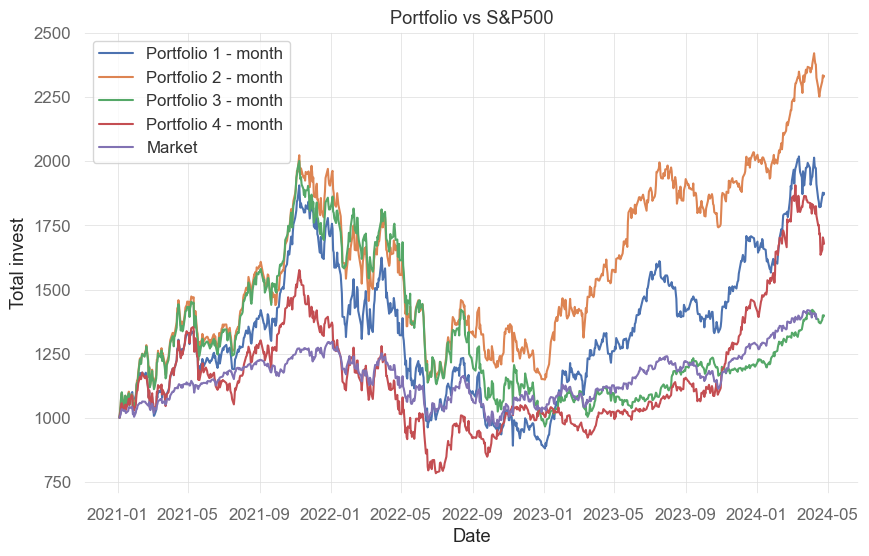

In [80]:
for i in range(len(portfolio_full)):  # Plot df_portfolio
    plt.plot(portfolio_full[i].index, portfolio_full[i], label= 'Portfolio {} - month'.format(i+1))
plt.xlabel('Date')
plt.ylabel('Total invest')
plt.title('Portfolio vs S&P500')
plt.plot(market.index, market, label= 'Market')
# Add legend
plt.legend()

# Show the plot
plt.show()

## Risk Measurements

In [81]:
def sharpe_ratio(return_series ,N,rf):
    mean = return_series.mean() * N -rf
    sigma = return_series.std() * np.sqrt(N)
    return mean / sigma

def sortino_ratio(series ,N,rf):
    mean = series.mean() * N -rf
    std_neg = series[series<0].std()*np.sqrt(N)
    return mean/std_neg

def maxDD(return_series):
    comp_ret = (return_series+1).cumprod()
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak)-1
    return dd.min()

In [82]:
# Calculation of the principal risk variables
N = 255  # 255 trading days in a year
rf = 0.01  # 1% risk-free rate

# Initialize lists to store risk metrics for each portfolio
sharpe_list = []
sortino_list = []
max_draw_list = []
calmar_list = []
beta_list = []
VaR_95_list = []
VaR_99_list = []

# Iterate over each portfolio DataFrame in portfolio_full
for portfolio_df in portfolio_full:
    # Calculate returns for the portfolio
    return_portfolio = portfolio_df.pct_change().dropna()
    return_market = market.pct_change().dropna()
    
    # Calculate risk metrics for the portfolio
    sharpe = sharpe_ratio(return_portfolio, N, rf)
    sortino = sortino_ratio(return_portfolio, N, rf)
    max_draw = maxDD(return_portfolio)
    calmar = return_portfolio.mean() * N / abs(max_draw)
    x = np.array(return_portfolio[0:len(return_market)]).reshape((-1,1))
    y = np.array(return_market[0:len(return_market)]).reshape((-1,1))
    model = LinearRegression().fit(x, y)
    beta = model.coef_[0][0]
    mean = np.mean(return_portfolio)
    std_dev = np.std(return_portfolio)
    VaR_95 = norm.ppf(0.05, mean, std_dev)
    VaR_99 = norm.ppf(0.01, mean, std_dev)

    # Append risk metrics to the respective lists
    sharpe_list.append(sharpe)
    sortino_list.append(sortino)
    max_draw_list.append(max_draw)
    calmar_list.append(calmar)
    beta_list.append(beta)
    VaR_95_list.append(VaR_95)
    VaR_99_list.append(VaR_99)

# Create a DataFrame to display the risk metrics
risk_metrics_df = pd.DataFrame({
    'Allocation time': ['{} month'.format(i+1) for i in range(len(portfolio_full))],  # Use index of portfolios as labels
    'Sharpe Ratio': sharpe_list,
    'Sortino Ratio': sortino_list,
    'Max Drawdown': max_draw_list,
    'Calmar Ratio': calmar_list,
    'Beta': beta_list,
    'VaR 95': VaR_95_list,
    'VaR 99': VaR_99_list
})

# Print the DataFrame
risk_metrics_df

,Allocation time,Sharpe Ratio,Sortino Ratio,Max Drawdown,Calmar Ratio,Beta,VaR 95,VaR 99
0,1 month,0.713769,0.989156,-0.538054,0.464024,0.376065,-0.033587,-0.047909
1,2 month,0.934669,1.298925,-0.435436,0.717171,0.388487,-0.032068,-0.045862
2,3 month,0.452168,0.585943,-0.517417,0.296448,0.394802,-0.032043,-0.045568
3,4 month,0.641163,0.872960,-0.502879,0.408508,0.412021,-0.030572,-0.043572


# Table different machine learning

## Calculate weights all ML algorithms

In [117]:
# Initial data
end=fecha
# number of months
months = 2
periods = int(12* years / months)
leng_period= 30 * months

In [118]:
total_weight=[]
min_assets= 10
functions = [ RF, XG , SV]
function_names = [ 'Random Forest', 'XGBoost',  'Support Vector Machines']


for func, func_name in zip(functions, function_names):
    end1=end
    weights=[]
    table = PrettyTable()
    table.field_names = ["Start Date", "End Date",  f"MSE {func_name}"]
    for i in range(periods):
      # Convert the end date string to a datetime object
      end_date = datetime.strptime(end1, "%Y-%m-%d")
      # Calculate the start date as one year before the end date
      start_date = end_date - timedelta(days=365*years_training)
      # Convert the start date to a string in the same format as the end date
      start = start_date.strftime("%Y-%m-%d")
      end1 = end_date.strftime("%Y-%m-%d")
      print(start, end1)
      #Call the prices from prices of all the asssets
      df_prices=df_prices_all[start:end1]
      #Machine learning algorithm to calculate the expected returns
      ml_data=macro_prices[start:end1]
      expected_returns, mse = func(ml_data)
      table.add_row([start, end1, round(mse,3)])
      #weigt using CVXPY
      #weight=markowitz(df_prices, initial_weight, expected_returns)
      #weigt using spicy optimizer
      weight=weight_scipy(df_prices, initial_weight, expected_returns, min_assets=min_assets)
      #weight using HRP
      #weight = weights_hrp(df_prices)
      # Append the weights for this period to the matrix
      weights.append(weight)
      end_date += timedelta(days=leng_period)
      end1 = end_date.strftime("%Y-%m-%d")
      initial_weight = weight
    total_weight.append(weights)
    print(table)

2020-01-02 2021-01-01
Mean Squared Error: 0.02807083987980503
2020-03-02 2021-03-02
Mean Squared Error: 0.04141602347795641
2020-05-01 2021-05-01
Mean Squared Error: 0.017314044007436667
2020-06-30 2021-06-30
Mean Squared Error: 0.02708440242368101
2020-08-29 2021-08-29
Mean Squared Error: 0.00950122501553738
2020-10-28 2021-10-28
Mean Squared Error: 0.014512378038410443
2020-12-27 2021-12-27
Mean Squared Error: 0.00815491401750499
2021-02-25 2022-02-25
Mean Squared Error: 0.01546627991820593
2021-04-26 2022-04-26
Mean Squared Error: 0.011831051682070572
2021-06-25 2022-06-25
Mean Squared Error: 0.016260718679459846
2021-08-24 2022-08-24
Mean Squared Error: 0.017833586744403333
2021-10-23 2022-10-23
Mean Squared Error: 0.012092284415268115
2021-12-22 2022-12-22
Mean Squared Error: 0.015033028243231085
2022-02-20 2023-02-20
Mean Squared Error: 0.029177809639993807
2022-04-21 2023-04-21
Mean Squared Error: 0.0111491207096183
2022-06-20 2023-06-20
Mean Squared Error: 0.009875759942846386


## Evaluation of portfolio

In [119]:
start= fecha
start_date = datetime.strptime(start, "%Y-%m-%d")
end_date = start_date + timedelta(days=leng_period*periods)
end = end_date.strftime("%Y-%m-%d")

print("Start Date:", start)
print("End Date:", end)

initial_market_prices = yf.download("^GSPC",start=start,end=end)['Adj Close']
initial_df_prices = yf.download(assets,start=start,end=end)['Adj Close']
initial_df_prices = initial_df_prices.dropna()

[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]

Start Date: 2021-01-01
End Date: 2024-04-15


[*********************100%%**********************]  55 of 55 completed


In [120]:
def count_differing_values(array1, array2, threshold):
    # Convert lists to numpy arrays
    array1 = np.array(array1)
    array2 = np.array(array2)

    # Calculate absolute difference between arrays
    diff = np.abs(array1 - array2)
    # Count differing values based on threshold
    differing_count = np.sum(diff > threshold)
    return differing_count

In [121]:
portfolio_full=[]
for j in range(len(functions)):
    start1=start
    Total_invest=1_000
    bl_portfolio = []
    market=[]
    portfolio=[]
    table = PrettyTable()
    table.field_names = ["Start Date", "End Date"]
    weights = total_weight [j]
    for x in range(periods):
        # Convert the start date string to a datetime object
        start_date = datetime.strptime(start1, "%Y-%m-%d")+ timedelta(days=1)
        #sum leng period to the end date
        end_date = start_date + timedelta(days=leng_period)
        # Convert the end date to a string in the same format as the end date
        end = end_date.strftime("%Y-%m-%d")
        start1= start_date.strftime("%Y-%m-%d")
        print(start1, end)
        table.add_row([start1, end])
        #Call the prices from market
        market_prices=market_prices_all[start1:end]
        #Call the prices from prices of all the asssets
        df_prices = df_prices_all[start1:end]
        portfolio= np.zeros(len(df_prices))
        # Loop through each asset and its weight, and calculate the contribution to the portfolio
        for i in range(len(assets)):
            asset_name = assets[i]
            #print(asset_name,df_prices[asset_name][0])
            asset_price = df_prices[asset_name]/df_prices[asset_name][0]
            asset_weight = weights[x][i]
            portfolio += asset_price * asset_weight
        portf = portfolio*Total_invest

        # Recalculation of the new total invest by the end of the period
        cost = 0.15 # price for buying or sell a faction of a share (hapi)
        if x==0:
            transactions=count_differing_values(weights[x], initial_weight, 1e-3)
        else:
            transactions = count_differing_values(weights[x], weights[x-1], 1e-3)
        total_cost = transactions*cost
        Total_invest=portfolio[-1]*Total_invest-total_cost
        bl_portfolio.append(portf)
        start_date += timedelta(days=leng_period)
        start1= start_date.strftime("%Y-%m-%d")
        #convert to a dataframe
        df_portfolio=pd.DataFrame(bl_portfolio)
        # Replace all the nan to value 0. When you do a dataframe it will create several row per each run and the columns are the dates
        df_portfolio.fillna(0, inplace=True)

        #transpose to have the date as row and all the run as columns
        df_portfolio = df_portfolio.transpose()
        #sum all the columns in the same row to have and unique value per row
        df_portfolio = df_portfolio.sum(axis=1)
    print(table)
    portfolio_full.append(df_portfolio)

2021-01-02 2021-03-03
2021-03-04 2021-05-03
2021-05-04 2021-07-03
2021-07-04 2021-09-02
2021-09-03 2021-11-02
2021-11-03 2022-01-02
2022-01-03 2022-03-04
2022-03-05 2022-05-04
2022-05-05 2022-07-04
2022-07-05 2022-09-03
2022-09-04 2022-11-03
2022-11-04 2023-01-03
2023-01-04 2023-03-05
2023-03-06 2023-05-05
2023-05-06 2023-07-05
2023-07-06 2023-09-04
2023-09-05 2023-11-04
2023-11-05 2024-01-04
2024-01-05 2024-03-05
2024-03-06 2024-05-05
+------------+------------+
| Start Date |  End Date  |
+------------+------------+
| 2021-01-02 | 2021-03-03 |
| 2021-03-04 | 2021-05-03 |
| 2021-05-04 | 2021-07-03 |
| 2021-07-04 | 2021-09-02 |
| 2021-09-03 | 2021-11-02 |
| 2021-11-03 | 2022-01-02 |
| 2022-01-03 | 2022-03-04 |
| 2022-03-05 | 2022-05-04 |
| 2022-05-05 | 2022-07-04 |
| 2022-07-05 | 2022-09-03 |
| 2022-09-04 | 2022-11-03 |
| 2022-11-04 | 2023-01-03 |
| 2023-01-04 | 2023-03-05 |
| 2023-03-06 | 2023-05-05 |
| 2023-05-06 | 2023-07-05 |
| 2023-07-06 | 2023-09-04 |
| 2023-09-05 | 2023-11-04 |


In [122]:
start= fecha
Total_invest_market=1_000
start_date = datetime.strptime(start, "%Y-%m-%d")
end_date = start_date + timedelta(days=leng_period*periods)
end = end_date.strftime("%Y-%m-%d")
sp500 = yf.download("^GSPC",start=start,end=end)['Adj Close']
market=sp500/sp500[0]*Total_invest_market

[*********************100%%**********************]  1 of 1 completed


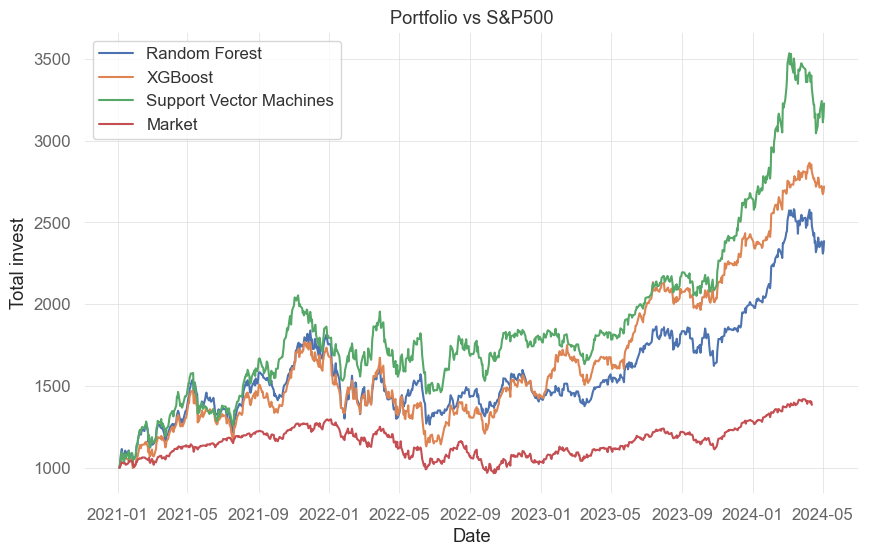

In [123]:
for i in range(len(portfolio_full)):  # Plot df_portfolio
    plt.plot(portfolio_full[i].index, portfolio_full[i], label= f"{function_names[i]}")
plt.xlabel('Date')
plt.ylabel('Total invest')
plt.title('Portfolio vs S&P500')
plt.plot(market.index, market, label= 'Market')
# Add legend
plt.legend()

# Show the plot
plt.show()

## Risk Measurements

In [124]:
def sharpe_ratio(return_series ,N,rf):
    mean = return_series.mean() * N -rf
    sigma = return_series.std() * np.sqrt(N)
    return mean / sigma

def sortino_ratio(series ,N,rf):
    mean = series.mean() * N -rf
    std_neg = series[series<0].std()*np.sqrt(N)
    return mean/std_neg

def maxDD(return_series):
    comp_ret = (return_series+1).cumprod()
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak)-1
    return dd.min()

In [125]:
# Calculation of the principal risk variables
N = 255  # 255 trading days in a year
rf = 0.01  # 1% risk-free rate

# Initialize lists to store risk metrics for each portfolio
sharpe_list = []
sortino_list = []
max_draw_list = []
calmar_list = []
beta_list = []
VaR_95_list = []
VaR_99_list = []

# Iterate over each portfolio DataFrame in portfolio_full
for portfolio_df in portfolio_full:
    # Calculate returns for the portfolio
    return_portfolio = portfolio_df.pct_change().dropna()
    return_market = market.pct_change().dropna()
    
    # Calculate risk metrics for the portfolio
    sharpe = sharpe_ratio(return_portfolio, N, rf)
    sortino = sortino_ratio(return_portfolio, N, rf)
    max_draw = maxDD(return_portfolio)
    calmar = return_portfolio.mean() * N / abs(max_draw)
    x = np.array(return_portfolio[0:len(return_market)]).reshape((-1,1))
    y = np.array(return_market).reshape((-1,1))
    model = LinearRegression().fit(x, y)
    beta = model.coef_[0][0]
    mean = np.mean(return_portfolio)
    std_dev = np.std(return_portfolio)
    VaR_95 = norm.ppf(0.05, mean, std_dev)
    VaR_99 = norm.ppf(0.01, mean, std_dev)

    # Append risk metrics to the respective lists
    sharpe_list.append(sharpe)
    sortino_list.append(sortino)
    max_draw_list.append(max_draw)
    calmar_list.append(calmar)
    beta_list.append(beta)
    VaR_95_list.append(VaR_95)
    VaR_99_list.append(VaR_99)

# Create a DataFrame to display the risk metrics
risk_metrics_df = pd.DataFrame({
    'Machine learning algorithm': [f" {function_names[i]}" for i in range(len(portfolio_full))],  # Use index of portfolios as labels
    'Sharpe Ratio': sharpe_list,
    'Sortino Ratio': sortino_list,
    'Max Drawdown': max_draw_list,
    'Calmar Ratio': calmar_list,
    'Beta': beta_list,
    'VaR 95': VaR_95_list,
    'VaR 99': VaR_99_list
})

# Print the DataFrame
risk_metrics_df

,Machine learning algorithm,Sharpe Ratio,Sortino Ratio,Max Drawdown,Calmar Ratio,Beta,VaR 95,VaR 99
0,Random Forest,1.023665,1.460347,-0.312878,0.980678,0.389860,-0.028647,-0.041015
1,XGBoost,1.153144,1.660164,-0.360815,0.963193,0.436399,-0.028769,-0.041254
2,Support Vector Machines,1.320188,1.883655,-0.292937,1.367557,0.394991,-0.028887,-0.041506


# Table different portfolio models

## Calculate weights for models

In [139]:
# Initial data
end=fecha
# number of months
months = 2
periods = int(12* years / months)
leng_period= 30 * months

In [137]:
total_weight=[]
portfolio_names = [ 'Markowitz', 'HRP']

In [140]:
weights=[]
table = PrettyTable()
table.field_names = ["Start Date", "End Date"]
min_assets= 7
for i in range(periods):
  # Convert the end date string to a datetime object
  end_date = datetime.strptime(end, "%Y-%m-%d")
  # Calculate the start date as one year before the end date
  start_date = end_date - timedelta(days=365*years_training)
  # Convert the start date to a string in the same format as the end date
  start = start_date.strftime("%Y-%m-%d")
  end = end_date.strftime("%Y-%m-%d")
  print(start, end)
  table.add_row([start, end])
  #Call the prices from prices of all the asssets
  df_prices=df_prices_all[start:end]
  #Machine learning algorithm to calculate the expected returns
  ml_data=macro_prices[start:end]
  expected_returns, mse = SV(ml_data)
  #weigt using CVXPY
  #weight=markowitz(df_prices, initial_weight, expected_returns)
  #weigt using spicy optimizer
  weight=weight_scipy(df_prices, initial_weight, expected_returns, min_assets=min_assets)
  #weight using HRP
  #weight = weights_hrp(df_prices)
  # Append the weights for this period to the matrix
  weights.append(weight)
  end_date += timedelta(days=leng_period)
  end = end_date.strftime("%Y-%m-%d")
  initial_weight = weight
print(table)
total_weight.append(weights)

2020-01-02 2021-01-01
2020-03-02 2021-03-02
2020-05-01 2021-05-01
2020-06-30 2021-06-30
2020-08-29 2021-08-29
2020-10-28 2021-10-28
2020-12-27 2021-12-27
2021-02-25 2022-02-25
2021-04-26 2022-04-26
2021-06-25 2022-06-25
2021-08-24 2022-08-24
2021-10-23 2022-10-23
2021-12-22 2022-12-22
2022-02-20 2023-02-20
2022-04-21 2023-04-21
2022-06-20 2023-06-20
2022-08-19 2023-08-19
2022-10-18 2023-10-18
2022-12-17 2023-12-17
2023-02-15 2024-02-15
+------------+------------+
| Start Date |  End Date  |
+------------+------------+
| 2020-01-02 | 2021-01-01 |
| 2020-03-02 | 2021-03-02 |
| 2020-05-01 | 2021-05-01 |
| 2020-06-30 | 2021-06-30 |
| 2020-08-29 | 2021-08-29 |
| 2020-10-28 | 2021-10-28 |
| 2020-12-27 | 2021-12-27 |
| 2021-02-25 | 2022-02-25 |
| 2021-04-26 | 2022-04-26 |
| 2021-06-25 | 2022-06-25 |
| 2021-08-24 | 2022-08-24 |
| 2021-10-23 | 2022-10-23 |
| 2021-12-22 | 2022-12-22 |
| 2022-02-20 | 2023-02-20 |
| 2022-04-21 | 2023-04-21 |
| 2022-06-20 | 2023-06-20 |
| 2022-08-19 | 2023-08-19 |


In [141]:
# Initial data
end=fecha

In [142]:
weights=[]
table = PrettyTable()
table.field_names = ["Start Date", "End Date"]
min_assets= 15
for i in range(periods):
  # Convert the end date string to a datetime object
  end_date = datetime.strptime(end, "%Y-%m-%d")
  # Calculate the start date as one year before the end date
  start_date = end_date - timedelta(days=365*years_training)
  # Convert the start date to a string in the same format as the end date
  start = start_date.strftime("%Y-%m-%d")
  end = end_date.strftime("%Y-%m-%d")
  print(start, end)
  table.add_row([start, end])
  #Call the prices from prices of all the asssets
  df_prices=df_prices_all[start:end]
  #Machine learning algorithm to calculate the expected returns
  #ml_data=macro_prices[start:end]
  #expected_returns = SV(ml_data)
  #weigt using CVXPY
  #weight=markowitz(df_prices, initial_weight, expected_returns)
  #weigt using spicy optimizer
  #weight=weight_scipy(df_prices, initial_weight, expected_returns, min_assets=min_assets)
  #weight using HRP
  weight = weights_hrp(df_prices)
  # Append the weights for this period to the matrix
  weights.append(weight)
  end_date += timedelta(days=leng_period)
  end = end_date.strftime("%Y-%m-%d")
  initial_weight = weight
print(table)
total_weight.append(weights)

2020-01-02 2021-01-01
Mean Squared Error: 0.020765246498231332
2020-03-02 2021-03-02
Mean Squared Error: 0.0373305584960383
2020-05-01 2021-05-01
Mean Squared Error: 0.015923586748721796
2020-06-30 2021-06-30
Mean Squared Error: 0.03360633069070765
2020-08-29 2021-08-29
Mean Squared Error: 0.009783161540526228
2020-10-28 2021-10-28
Mean Squared Error: 0.013984565799771224
2020-12-27 2021-12-27
Mean Squared Error: 0.008204466126295296
2021-02-25 2022-02-25
Mean Squared Error: 0.013501065635060644
2021-04-26 2022-04-26
Mean Squared Error: 0.011788221231410607
2021-06-25 2022-06-25
Mean Squared Error: 0.016753368471471342
2021-08-24 2022-08-24
Mean Squared Error: 0.016894601622273173
2021-10-23 2022-10-23
Mean Squared Error: 0.012988356120699991
2021-12-22 2022-12-22
Mean Squared Error: 0.016998213547960116
2022-02-20 2023-02-20
Mean Squared Error: 0.029940389824382217
2022-04-21 2023-04-21
Mean Squared Error: 0.015264327509377923
2022-06-20 2023-06-20
Mean Squared Error: 0.01035737238894

## Evaluation of portfolio

In [143]:
start= fecha
start_date = datetime.strptime(start, "%Y-%m-%d")
end_date = start_date + timedelta(days=leng_period*periods)
end = end_date.strftime("%Y-%m-%d")

print("Start Date:", start)
print("End Date:", end)

initial_market_prices = yf.download("^GSPC",start=start,end=end)['Adj Close']
initial_df_prices = yf.download(assets,start=start,end=end)['Adj Close']
initial_df_prices = initial_df_prices.dropna()

[*********************100%%**********************]  1 of 1 completed
[**                     4%%                      ]  2 of 55 completed

Start Date: 2021-01-01
End Date: 2024-04-15


[*********************100%%**********************]  55 of 55 completed


In [144]:
def count_differing_values(array1, array2, threshold):
    # Convert lists to numpy arrays
    array1 = np.array(array1)
    array2 = np.array(array2)

    # Calculate absolute difference between arrays
    diff = np.abs(array1 - array2)
    # Count differing values based on threshold
    differing_count = np.sum(diff > threshold)
    return differing_count

In [145]:
portfolio_full=[]
for j in range(len(total_weight)):
    start1=start
    Total_invest=1_000
    bl_portfolio = []
    market=[]
    portfolio=[]
    table = PrettyTable()
    table.field_names = ["Start Date", "End Date"]
    weights = total_weight [j]
    for x in range(periods):
        # Convert the start date string to a datetime object
        start_date = datetime.strptime(start1, "%Y-%m-%d")+ timedelta(days=1)
        #sum leng period to the end date
        end_date = start_date + timedelta(days=leng_period)
        # Convert the end date to a string in the same format as the end date
        end = end_date.strftime("%Y-%m-%d")
        start1= start_date.strftime("%Y-%m-%d")
        print(start1, end)
        table.add_row([start1, end])
        #Call the prices from market
        market_prices=market_prices_all[start1:end]
        #Call the prices from prices of all the asssets
        df_prices = df_prices_all[start1:end]
        portfolio= np.zeros(len(df_prices))
        # Loop through each asset and its weight, and calculate the contribution to the portfolio
        for i in range(len(assets)):
            asset_name = assets[i]
            #print(asset_name,df_prices[asset_name][0])
            asset_price = df_prices[asset_name]/df_prices[asset_name][0]
            asset_weight = weights[x][i]
            portfolio += asset_price * asset_weight
        portf = portfolio*Total_invest

        # Recalculation of the new total invest by the end of the period
        cost = 0.15 # price for buying or sell a faction of a share (hapi)
        if x==0:
            transactions=count_differing_values(weights[x], initial_weight, 1e-3)
        else:
            transactions = count_differing_values(weights[x], weights[x-1], 1e-3)
        total_cost = transactions*cost
        Total_invest=portfolio[-1]*Total_invest-total_cost
        bl_portfolio.append(portf)
        start_date += timedelta(days=leng_period)
        start1= start_date.strftime("%Y-%m-%d")
        #convert to a dataframe
        df_portfolio=pd.DataFrame(bl_portfolio)
        # Replace all the nan to value 0. When you do a dataframe it will create several row per each run and the columns are the dates
        df_portfolio.fillna(0, inplace=True)

        #transpose to have the date as row and all the run as columns
        df_portfolio = df_portfolio.transpose()
        #sum all the columns in the same row to have and unique value per row
        df_portfolio = df_portfolio.sum(axis=1)
    print(table)
    portfolio_full.append(df_portfolio)

2021-01-02 2021-03-03
2021-03-04 2021-05-03
2021-05-04 2021-07-03
2021-07-04 2021-09-02
2021-09-03 2021-11-02
2021-11-03 2022-01-02
2022-01-03 2022-03-04
2022-03-05 2022-05-04
2022-05-05 2022-07-04
2022-07-05 2022-09-03
2022-09-04 2022-11-03
2022-11-04 2023-01-03
2023-01-04 2023-03-05
2023-03-06 2023-05-05
2023-05-06 2023-07-05
2023-07-06 2023-09-04
2023-09-05 2023-11-04
2023-11-05 2024-01-04
2024-01-05 2024-03-05
2024-03-06 2024-05-05
+------------+------------+
| Start Date |  End Date  |
+------------+------------+
| 2021-01-02 | 2021-03-03 |
| 2021-03-04 | 2021-05-03 |
| 2021-05-04 | 2021-07-03 |
| 2021-07-04 | 2021-09-02 |
| 2021-09-03 | 2021-11-02 |
| 2021-11-03 | 2022-01-02 |
| 2022-01-03 | 2022-03-04 |
| 2022-03-05 | 2022-05-04 |
| 2022-05-05 | 2022-07-04 |
| 2022-07-05 | 2022-09-03 |
| 2022-09-04 | 2022-11-03 |
| 2022-11-04 | 2023-01-03 |
| 2023-01-04 | 2023-03-05 |
| 2023-03-06 | 2023-05-05 |
| 2023-05-06 | 2023-07-05 |
| 2023-07-06 | 2023-09-04 |
| 2023-09-05 | 2023-11-04 |


In [146]:
start= fecha
Total_invest_market=1_000
start_date = datetime.strptime(start, "%Y-%m-%d")
end_date = start_date + timedelta(days=leng_period*periods)
end = end_date.strftime("%Y-%m-%d")
sp500 = yf.download("^GSPC",start=start,end=end)['Adj Close']
market=sp500/sp500[0]*Total_invest_market

[*********************100%%**********************]  1 of 1 completed


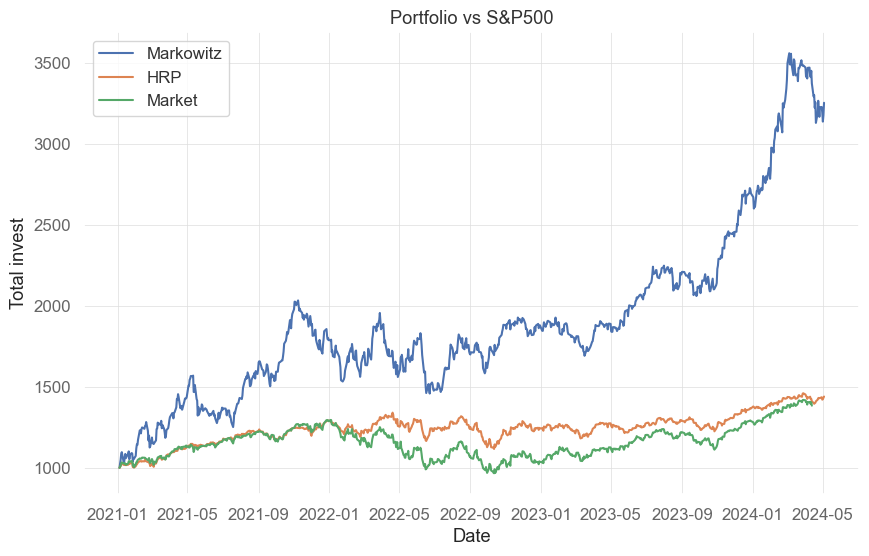

In [147]:
for i in range(len(portfolio_full)):  # Plot df_portfolio
    plt.plot(portfolio_full[i].index, portfolio_full[i], label= f"{portfolio_names[i]}")
plt.xlabel('Date')
plt.ylabel('Total invest')
plt.title('Portfolio vs S&P500')
plt.plot(market.index, market, label= 'Market')
# Add legend
plt.legend()

# Show the plot
plt.show()

## Risk Measurements

In [148]:
def sharpe_ratio(return_series ,N,rf):
    mean = return_series.mean() * N -rf
    sigma = return_series.std() * np.sqrt(N)
    return mean / sigma

def sortino_ratio(series ,N,rf):
    mean = series.mean() * N -rf
    std_neg = series[series<0].std()*np.sqrt(N)
    return mean/std_neg

def maxDD(return_series):
    comp_ret = (return_series+1).cumprod()
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak)-1
    return dd.min()

In [151]:
# Calculation of the principal risk variables
N = 255  # 255 trading days in a year
rf = 0.01  # 1% risk-free rate

# Initialize lists to store risk metrics for each portfolio
sharpe_list = []
sortino_list = []
max_draw_list = []
calmar_list = []
beta_list = []
VaR_95_list = []
VaR_99_list = []

# Iterate over each portfolio DataFrame in portfolio_full
for portfolio_df in portfolio_full:
    # Calculate returns for the portfolio
    return_portfolio = portfolio_df.pct_change().dropna()
    return_market = market.pct_change().dropna()
    
    # Calculate risk metrics for the portfolio
    sharpe = sharpe_ratio(return_portfolio, N, rf)
    sortino = sortino_ratio(return_portfolio, N, rf)
    max_draw = maxDD(return_portfolio)
    calmar = return_portfolio.mean() * N / abs(max_draw)
    x = np.array(return_portfolio[0:len(return_market)]).reshape((-1,1))
    y = np.array(return_market).reshape((-1,1))
    model = LinearRegression().fit(x, y)
    beta = model.coef_[0][0]
    mean = np.mean(return_portfolio)
    std_dev = np.std(return_portfolio)
    VaR_95 = norm.ppf(0.05, mean, std_dev)
    VaR_99 = norm.ppf(0.01, mean, std_dev)

    # Append risk metrics to the respective lists
    sharpe_list.append(sharpe)
    sortino_list.append(sortino)
    max_draw_list.append(max_draw)
    calmar_list.append(calmar)
    beta_list.append(beta)
    VaR_95_list.append(VaR_95)
    VaR_99_list.append(VaR_99)

# Create a DataFrame to display the risk metrics
risk_metrics_df = pd.DataFrame({
    'Portfolio Model': [f" {portfolio_names[i]}" for i in range(len(portfolio_full))],  # Use index of portfolios as labels
    'Sharpe Ratio': sharpe_list,
    'Sortino Ratio': sortino_list,
    'Max Drawdown': max_draw_list,
    'Calmar Ratio': calmar_list,
    'Beta': beta_list,
    'VaR 95': VaR_95_list,
    'VaR 99': VaR_99_list
})

# Print the DataFrame
risk_metrics_df

,Portfolio Model,Sharpe Ratio,Sortino Ratio,Max Drawdown,Calmar Ratio,Beta,VaR 95,VaR 99
0,Markowitz,1.326710,1.911536,-0.282805,1.426880,0.387813,-0.028953,-0.041604
1,HRP,0.845946,1.211550,-0.167339,0.713997,1.150059,-0.012854,-0.018374


# Table different quantity of assets in HRP model

## Calculate weights of all HRP

In [221]:
# Initial data
end=fecha
# number of months
months = 2
periods = int(12* years / months)
leng_period= 30 * months

total_weight=[]

In [222]:
for j in range(10, 51, 10):
    min_assets = j
    end1=end
    weights=[]
    table = PrettyTable()
    table.field_names = ["Start Date", "End Date"]
    for i in range(periods):
      # Convert the end date string to a datetime object
      end_date = datetime.strptime(end1, "%Y-%m-%d")
      # Calculate the start date as one year before the end date
      start_date = end_date - timedelta(days=365*years_training)
      # Convert the start date to a string in the same format as the end date
      start = start_date.strftime("%Y-%m-%d")
      end1 = end_date.strftime("%Y-%m-%d")
      print(start, end1)
      #Call the prices from prices of all the asssets
      df_prices=df_prices_all[start:end1]
      #Machine learning algorithm to calculate the expected returns
      ml_data=macro_prices[start:end1]
      expected_returns, mse = SV(ml_data)
      table.add_row([start, end1])
      #weigt using CVXPY
      #weight=markowitz(df_prices, initial_weight, expected_returns)
      #weigt using spicy optimizer
      #weight=weight_scipy(df_prices, initial_weight, expected_returns, min_assets=min_assets)
      #weight using HRP
    #weight using HRP
      # Get the indices of the top 15 assets with the highest expected returns
      top_indices = np.argsort(expected_returns)[-min_assets:][::-1]  # Get top 15 indices in descending order
      # Get the names of the top assets
      top_assets = [assets[i] for i in top_indices]
      #sort top_assets by name
      top_assets = sorted(top_assets)
      weight = weights_hrp(df_prices[top_assets])
      # Initialize dictionary to store combined assets and weights
      combined_assets = {}
      # Iterate over all assets
      for asset in assets:
            # Check if the asset is in the previous list
            if asset in top_assets:
                # If yes, get the corresponding weight
                t_weight = weight[top_assets.index(asset)]
            else:
                # If not, assign a weight of zero
                t_weight = 0.0
            # Add the asset and weight to the dictionary
            combined_assets[asset] = t_weight

      # Append the weights for this period to the matrix
      weights.append([pair[1] for pair in list(combined_assets.items())])

      end_date += timedelta(days=leng_period)
      end1 = end_date.strftime("%Y-%m-%d")
      initial_weight = weight
    total_weight.append(weights)
    print(table)

2020-01-02 2021-01-01
2020-03-02 2021-03-02
2020-05-01 2021-05-01
2020-06-30 2021-06-30
2020-08-29 2021-08-29
2020-10-28 2021-10-28
2020-12-27 2021-12-27
2021-02-25 2022-02-25
2021-04-26 2022-04-26
2021-06-25 2022-06-25
2021-08-24 2022-08-24
2021-10-23 2022-10-23
2021-12-22 2022-12-22
2022-02-20 2023-02-20
2022-04-21 2023-04-21
2022-06-20 2023-06-20
2022-08-19 2023-08-19
2022-10-18 2023-10-18
2022-12-17 2023-12-17
2023-02-15 2024-02-15
+------------+------------+
| Start Date |  End Date  |
+------------+------------+
| 2020-01-02 | 2021-01-01 |
| 2020-03-02 | 2021-03-02 |
| 2020-05-01 | 2021-05-01 |
| 2020-06-30 | 2021-06-30 |
| 2020-08-29 | 2021-08-29 |
| 2020-10-28 | 2021-10-28 |
| 2020-12-27 | 2021-12-27 |
| 2021-02-25 | 2022-02-25 |
| 2021-04-26 | 2022-04-26 |
| 2021-06-25 | 2022-06-25 |
| 2021-08-24 | 2022-08-24 |
| 2021-10-23 | 2022-10-23 |
| 2021-12-22 | 2022-12-22 |
| 2022-02-20 | 2023-02-20 |
| 2022-04-21 | 2023-04-21 |
| 2022-06-20 | 2023-06-20 |
| 2022-08-19 | 2023-08-19 |


## Evaluation of portfolio

In [223]:
start= fecha
start_date = datetime.strptime(start, "%Y-%m-%d")
end_date = start_date + timedelta(days=leng_period*periods)
end = end_date.strftime("%Y-%m-%d")

print("Start Date:", start)
print("End Date:", end)

initial_market_prices = yf.download("^GSPC",start=start,end=end)['Adj Close']
initial_df_prices = yf.download(assets,start=start,end=end)['Adj Close']
initial_df_prices = initial_df_prices.dropna()

[*********************100%%**********************]  1 of 1 completed
[***                    7%%                      ]  4 of 55 completed

Start Date: 2021-01-01
End Date: 2024-04-15


[*********************100%%**********************]  55 of 55 completed


In [224]:
def count_differing_values(array1, array2, threshold):
    # Convert lists to numpy arrays
    array1 = np.array(array1)
    array2 = np.array(array2)

    # Calculate absolute difference between arrays
    diff = np.abs(array1 - array2)
    # Count differing values based on threshold
    differing_count = np.sum(diff > threshold)
    return differing_count

In [225]:
portfolio_full=[]
for j in range(len(total_weight)):
    start1=start
    Total_invest=1_000
    bl_portfolio = []
    market=[]
    portfolio=[]
    table = PrettyTable()
    table.field_names = ["Start Date", "End Date"]
    weights = total_weight [j-1]
    for x in range(periods):
        # Convert the start date string to a datetime object
        start_date = datetime.strptime(start1, "%Y-%m-%d")+ timedelta(days=1)
        #sum leng period to the end date
        end_date = start_date + timedelta(days=leng_period)
        # Convert the end date to a string in the same format as the end date
        end = end_date.strftime("%Y-%m-%d")
        start1= start_date.strftime("%Y-%m-%d")
        print(start1, end)
        table.add_row([start1, end])
        #Call the prices from market
        market_prices=market_prices_all[start1:end]
        #Call the prices from prices of all the asssets
        df_prices = df_prices_all[start1:end]
        portfolio= np.zeros(len(df_prices))
        # Loop through each asset and its weight, and calculate the contribution to the portfolio
        for i in range(len(assets)):
            asset_name = assets[i]
            #print(asset_name,df_prices[asset_name][0])
            asset_price = df_prices[asset_name]/df_prices[asset_name][0]
            asset_weight = weights[x][i]
            portfolio += asset_price * asset_weight
        portf = portfolio*Total_invest

        # Recalculation of the new total invest by the end of the period
        cost = 0.15 # price for buying or sell a faction of a share (hapi)
        if x==0:
            transactions=count_differing_values(weights[x], ini_weight, 1e-3)
        else:
            transactions = count_differing_values(weights[x], weights[x-1], 1e-3)
        total_cost = transactions*cost
        Total_invest=portfolio[-1]*Total_invest-total_cost
        bl_portfolio.append(portf)
        start_date += timedelta(days=leng_period)
        start1= start_date.strftime("%Y-%m-%d")
        #convert to a dataframe
        df_portfolio=pd.DataFrame(bl_portfolio)
        # Replace all the nan to value 0. When you do a dataframe it will create several row per each run and the columns are the dates
        df_portfolio.fillna(0, inplace=True)

        #transpose to have the date as row and all the run as columns
        df_portfolio = df_portfolio.transpose()
        #sum all the columns in the same row to have and unique value per row
        df_portfolio = df_portfolio.sum(axis=1)
    print(table)
    portfolio_full.append(df_portfolio)

2021-01-02 2021-03-03
2021-03-04 2021-05-03
2021-05-04 2021-07-03
2021-07-04 2021-09-02
2021-09-03 2021-11-02
2021-11-03 2022-01-02
2022-01-03 2022-03-04
2022-03-05 2022-05-04
2022-05-05 2022-07-04
2022-07-05 2022-09-03
2022-09-04 2022-11-03
2022-11-04 2023-01-03
2023-01-04 2023-03-05
2023-03-06 2023-05-05
2023-05-06 2023-07-05
2023-07-06 2023-09-04
2023-09-05 2023-11-04
2023-11-05 2024-01-04
2024-01-05 2024-03-05
2024-03-06 2024-05-05
+------------+------------+
| Start Date |  End Date  |
+------------+------------+
| 2021-01-02 | 2021-03-03 |
| 2021-03-04 | 2021-05-03 |
| 2021-05-04 | 2021-07-03 |
| 2021-07-04 | 2021-09-02 |
| 2021-09-03 | 2021-11-02 |
| 2021-11-03 | 2022-01-02 |
| 2022-01-03 | 2022-03-04 |
| 2022-03-05 | 2022-05-04 |
| 2022-05-05 | 2022-07-04 |
| 2022-07-05 | 2022-09-03 |
| 2022-09-04 | 2022-11-03 |
| 2022-11-04 | 2023-01-03 |
| 2023-01-04 | 2023-03-05 |
| 2023-03-06 | 2023-05-05 |
| 2023-05-06 | 2023-07-05 |
| 2023-07-06 | 2023-09-04 |
| 2023-09-05 | 2023-11-04 |


In [226]:
start= fecha
Total_invest_market=1_000
start_date = datetime.strptime(start, "%Y-%m-%d")
end_date = start_date + timedelta(days=leng_period*periods)
end = end_date.strftime("%Y-%m-%d")
sp500 = yf.download("^GSPC",start=start,end=end)['Adj Close']
market=sp500/sp500[0]*Total_invest_market

[*********************100%%**********************]  1 of 1 completed


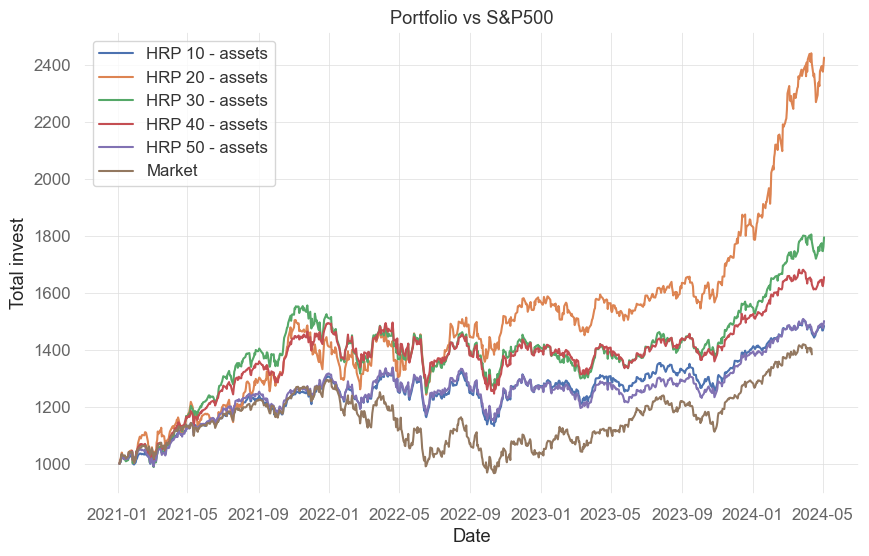

In [227]:
for i in range(len(portfolio_full)):  # Plot df_portfolio
    plt.plot(portfolio_full[i].index, portfolio_full[i], label= 'HRP {} - assets'.format((i+1)*10))
plt.xlabel('Date')
plt.ylabel('Total invest')
plt.title('Portfolio vs S&P500')
plt.plot(market.index, market, label= 'Market')
# Add legend
plt.legend()

# Show the plot
plt.show()

## Risk Measurements

In [228]:
def sharpe_ratio(return_series ,N,rf):
    mean = return_series.mean() * N -rf
    sigma = return_series.std() * np.sqrt(N)
    return mean / sigma

def sortino_ratio(series ,N,rf):
    mean = series.mean() * N -rf
    std_neg = series[series<0].std()*np.sqrt(N)
    return mean/std_neg

def maxDD(return_series):
    comp_ret = (return_series+1).cumprod()
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak)-1
    return dd.min()

In [229]:
# Calculation of the principal risk variables
N = 255  # 255 trading days in a year
rf = 0.01  # 1% risk-free rate

# Initialize lists to store risk metrics for each portfolio
sharpe_list = []
sortino_list = []
max_draw_list = []
calmar_list = []
beta_list = []
VaR_95_list = []
VaR_99_list = []

# Iterate over each portfolio DataFrame in portfolio_full
for portfolio_df in portfolio_full:
    # Calculate returns for the portfolio
    return_portfolio = portfolio_df.pct_change().dropna()
    return_market = market.pct_change().dropna()
    
    # Calculate risk metrics for the portfolio
    sharpe = sharpe_ratio(return_portfolio, N, rf)
    sortino = sortino_ratio(return_portfolio, N, rf)
    max_draw = maxDD(return_portfolio)
    calmar = return_portfolio.mean() * N / abs(max_draw)
    x = np.array(return_portfolio[0:len(return_market)]).reshape((-1,1))
    y = np.array(return_market[0:len(return_market)]).reshape((-1,1))
    model = LinearRegression().fit(x, y)
    beta = model.coef_[0][0]
    mean = np.mean(return_portfolio)
    std_dev = np.std(return_portfolio)
    VaR_95 = norm.ppf(0.05, mean, std_dev)
    VaR_99 = norm.ppf(0.01, mean, std_dev)

    # Append risk metrics to the respective lists
    sharpe_list.append(sharpe)
    sortino_list.append(sortino)
    max_draw_list.append(max_draw)
    calmar_list.append(calmar)
    beta_list.append(beta)
    VaR_95_list.append(VaR_95)
    VaR_99_list.append(VaR_99)

# Create a DataFrame to display the risk metrics
risk_metrics_df = pd.DataFrame({
    'Allocation time': ['HRP with {} assets'.format((i+1)*10) for i in range(len(portfolio_full))],  # Use index of portfolios as labels
    'Sharpe Ratio': sharpe_list,
    'Sortino Ratio': sortino_list,
    'Max Drawdown': max_draw_list,
    'Calmar Ratio': calmar_list,
    'Beta': beta_list,
    'VaR 95': VaR_95_list,
    'VaR 99': VaR_99_list
})

# Print the DataFrame
risk_metrics_df

,Allocation time,Sharpe Ratio,Sortino Ratio,Max Drawdown,Calmar Ratio,Beta,VaR 95,VaR 99
0,HRP with 10 assets,0.905355,1.320354,-0.152279,0.845385,1.141626,-0.012996,-0.018589
1,HRP with 20 assets,1.413168,2.064381,-0.174006,1.663884,0.657844,-0.019227,-0.027663
2,HRP with 30 assets,1.120704,1.581894,-0.197624,0.967812,0.895534,-0.015900,-0.022798
3,HRP with 40 assets,1.072291,1.527678,-0.166973,0.980956,1.036442,-0.014122,-0.020240
4,HRP with 50 assets,0.927919,1.361191,-0.141474,0.935817,1.131217,-0.013059,-0.018685
